# Threshold Strategy (Percentile, Z-score, Rolling-STD + Severity)

### Setup + Imports

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.metrics import mae, rmse, mape

In [3]:
df = pd.read_csv(
    "../data/processed/hourly_energy.csv",
    parse_dates=["datetime"],
    index_col="datetime"
).sort_index()

target = "Global_active_power"
df.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,4.2229
2006-12-16 18:00:00,3.6322
2006-12-16 19:00:00,3.4002
2006-12-16 20:00:00,3.2686
2006-12-16 21:00:00,3.0565


### Feature Engineering v2

In [4]:
# base time features 
df_feat = df.copy()

df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["month"] = df_feat.index.month

In [5]:
# lag features 
df_feat["lag_1"] = df_feat[target].shift(1)
df_feat["lag_24"] = df_feat[target].shift(24)
df_feat["lag_168"] = df_feat[target].shift(168)

In [6]:
# rolling features 

# rolling mean(24hr)
df_feat["rolling_mean_24"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=24)
    .mean()
)

# rolling std(24hr)
df_feat["rolling_std_24"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=24)
    .std()
)

# rolling mean(7days = 168hours)
df_feat["rolling_mean_168"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=168)
    .mean()
)

In [7]:
# cyclical encoding
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

In [8]:
# drop NaNs
df_feat = df_feat.dropna()
df_feat.shape

(34421, 12)

### Time Split

In [9]:
# create X and y
feature_cols = [
    "dayofweek",
    "month",
    "hour_sin",
    "hour_cos",
    "lag_1",
    "lag_24",
    "lag_168",
    "rolling_mean_24",
    "rolling_std_24",
    "rolling_mean_168"
]

X = df_feat[feature_cols]
y = df_feat[target]

X.head(), y.head()

(                     dayofweek  month  hour_sin      hour_cos   lag_1  lag_24  \
 datetime                                                                        
 2006-12-23 17:00:00          5     12 -0.965926 -2.588190e-01  4.3491  1.4968   
 2006-12-23 18:00:00          5     12 -1.000000 -1.836970e-16  5.4525  2.6870   
 2006-12-23 19:00:00          5     12 -0.965926  2.588190e-01  3.8794  3.9382   
 2006-12-23 20:00:00          5     12 -0.866025  5.000000e-01  4.1178  3.5361   
 2006-12-23 21:00:00          5     12 -0.707107  7.071068e-01  4.1814  4.5487   
 
                      lag_168  rolling_mean_24  rolling_std_24  \
 datetime                                                        
 2006-12-23 17:00:00   4.2229         2.934900        0.990192   
 2006-12-23 18:00:00   3.6322         3.099721        1.066674   
 2006-12-23 19:00:00   3.4002         3.149404        1.074357   
 2006-12-23 20:00:00   3.2686         3.156887        1.080697   
 2006-12-23 21:00:00   3.056

In [10]:
n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

### Load Saved Model + Evaluation

In [11]:
MODEL_PATH = "../models/forecast_pipeline_v1.joblib"
model = joblib.load(MODEL_PATH)


y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

**Build df_val and df_test with residuals**

In [12]:
df_val = pd.DataFrame({
    "actual": y_val.values,
    "predicted": y_val_pred
}, index=y_val.index)

df_val["residual"] = df_val["actual"] - df_val["predicted"]
df_val["abs_residual"] = np.abs(df_val["residual"])

df_test = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_test_pred
}, index=y_test.index)

df_test["residual"] = df_test["actual"] - df_test["predicted"]
df_test["abs_residual"] = np.abs(df_test["residual"])

### Strategy A — 95th Percentile Threshold

In [13]:
# Fit threshold on validation residuals
thr_p95 = np.percentile(df_val["abs_residual"], 95)
thr_p95

np.float64(1.0433715290114156)

In [14]:
# flag anomalies
df_val["anom_p95"] = df_val["abs_residual"] > thr_p95
df_test["anom_p95"] = df_test["abs_residual"] > thr_p95

df_val["anom_p95"].value_counts(), df_test["anom_p95"].value_counts()

(anom_p95
 False    4904
 True      259
 Name: count, dtype: int64,
 anom_p95
 False    4947
 True      217
 Name: count, dtype: int64)

### Strategy B — Z-score Threshold

In [15]:
# Fit μ(mean) and σ(std) on validation
mu = df_val["residual"].mean()
sigma = df_val["residual"].std()

mu, sigma

(np.float64(-0.007702509164234648), np.float64(0.4949288496333567))

In [16]:
# Compute z-score
df_val["z"] = (df_val["residual"] - mu) / sigma
df_test["z"] = (df_test["residual"] - mu) / sigma

In [17]:
Z_THR = 3.0

df_val["anom_z"] = np.abs(df_val["z"]) > Z_THR
df_test["anom_z"] = np.abs(df_test["z"]) > Z_THR

df_val["anom_z"].value_counts(), df_test["anom_z"].value_counts()

(anom_z
 False    5085
 True       78
 Name: count, dtype: int64,
 anom_z
 False    5102
 True       62
 Name: count, dtype: int64)

### Strategy C — Rolling Std-based Threshold

In [18]:
# Attach rolling_std_24
rolling_std = df_feat["rolling_std_24"]

df_val["rolling_std_24"] = rolling_std.loc[df_val.index]
df_test["rolling_std_24"] = rolling_std.loc[df_test.index]

In [19]:
# Avoid division by zero
EPS = 1e-6
df_val["rolling_std_24"] = df_val["rolling_std_24"].clip(lower=EPS)
df_test["rolling_std_24"] = df_test["rolling_std_24"].clip(lower=EPS)

In [20]:
# Define “severity score”
df_val["severity"] = df_val["abs_residual"] / df_val["rolling_std_24"]
df_test["severity"] = df_test["abs_residual"] / df_test["rolling_std_24"]

In [21]:
SEV_THR = 3.0

df_val["anom_sev"] = df_val["severity"] > SEV_THR
df_test["anom_sev"] = df_test["severity"] > SEV_THR

df_val["anom_sev"].value_counts(), df_test["anom_sev"].value_counts()

(anom_sev
 False    5098
 True       65
 Name: count, dtype: int64,
 anom_sev
 False    4958
 True      206
 Name: count, dtype: int64)

### Compare Strategies

In [22]:
summary = pd.DataFrame({
    "Strategy": ["P95", "Z=3", "Severity=3 (abs_res/rolling_std)"],
    "Val Anomalies": [
        int(df_val["anom_p95"].sum()),
        int(df_val["anom_z"].sum()),
        int(df_val["anom_sev"].sum())
    ],
    "Test Anomalies": [
        int(df_test["anom_p95"].sum()),
        int(df_test["anom_z"].sum()),
        int(df_test["anom_sev"].sum())
    ],
    "Val Rate %": [
        100 * df_val["anom_p95"].mean(),
        100 * df_val["anom_z"].mean(),
        100 * df_val["anom_sev"].mean()
    ]
})

summary

,Strategy,Val Anomalies,Test Anomalies,Val Rate %
0,P95,259,217,5.016463
1,Z=3,78,62,1.510750
2,Severity=3 (abs_res/rolling_std),65,206,1.258958


### Visualize Each Strategy

In [23]:
slice_val = df_val.iloc[:500].copy()

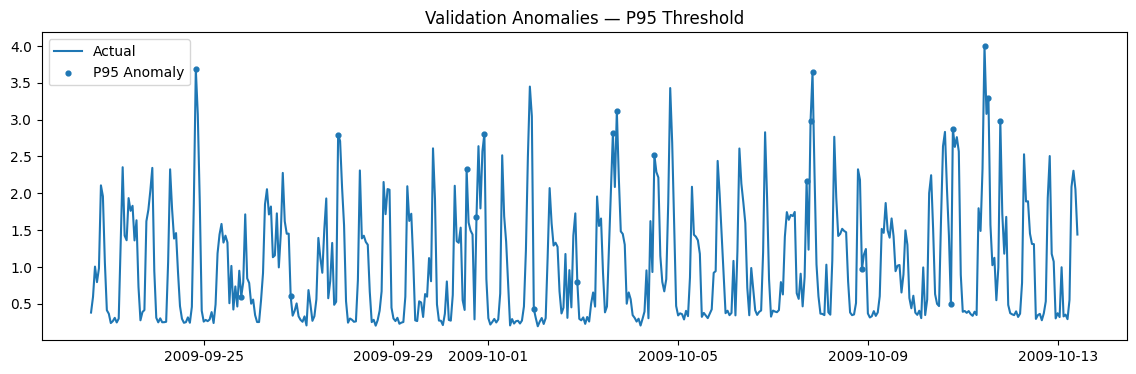

In [24]:
# Plot P95 anomalies
plt.figure(figsize=(14,4))
plt.plot(slice_val.index, slice_val["actual"], label="Actual")
plt.scatter(
    slice_val.index[slice_val["anom_p95"]],
    slice_val["actual"][slice_val["anom_p95"]],
    s=12,
    label="P95 Anomaly"
)
plt.title("Validation Anomalies — P95 Threshold")
plt.legend()
plt.show()

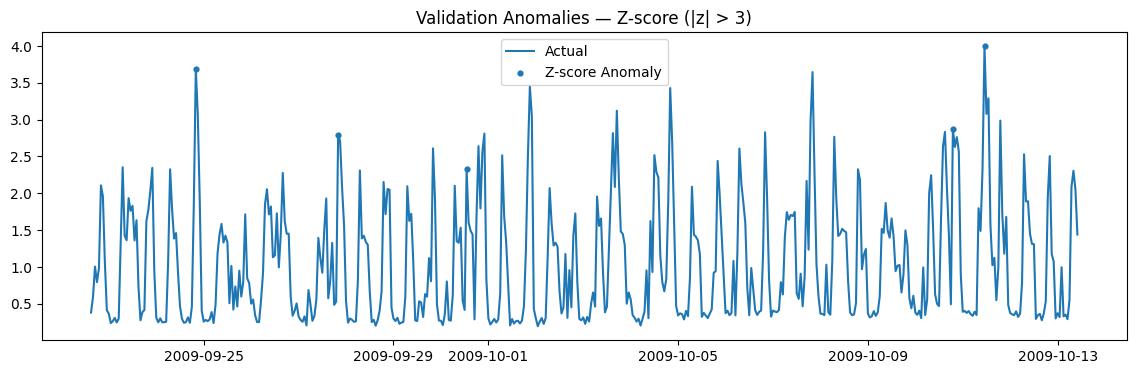

In [25]:
# Plot Z-score anomalies
plt.figure(figsize=(14,4))
plt.plot(slice_val.index, slice_val["actual"], label="Actual")
plt.scatter(
    slice_val.index[slice_val["anom_z"]],
    slice_val["actual"][slice_val["anom_z"]],
    s=12,
    label="Z-score Anomaly"
)
plt.title("Validation Anomalies — Z-score (|z| > 3)")
plt.legend()
plt.show()

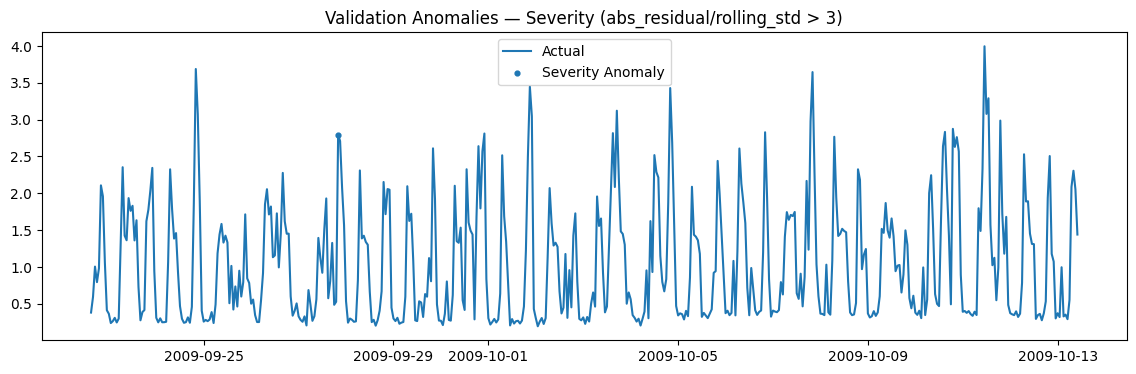

In [26]:
# Plot Severity anomalies
plt.figure(figsize=(14,4))
plt.plot(slice_val.index, slice_val["actual"], label="Actual")
plt.scatter(
    slice_val.index[slice_val["anom_sev"]],
    slice_val["actual"][slice_val["anom_sev"]],
    s=12,
    label="Severity Anomaly"
)
plt.title("Validation Anomalies — Severity (abs_residual/rolling_std > 3)")
plt.legend()
plt.show()

In [27]:
from src.model import ThresholdConfig, save_threshold_config

cfg = ThresholdConfig(
    strategy="p95",
    params={"thr_p95": float(thr_p95)}
)

save_threshold_config(cfg, "../models/threshold_v1.json")